
# Scene Recognition with Bag-of-Words
For this project, you will need to report performance for two
combinations of features / classifiers. It is suggested you code them in
this order, as well:
1. Nearest neighbor classifier
2. Bag of sift features and nearest neighbor classifier

The starter code is initialized to 'placeholder' just so that the starter
code does not crash when run unmodified and you can get a preview of how
results are presented.

## Setup

In [1]:
# Set up parameters, image paths and category list
%matplotlib inline
%load_ext autoreload
%autoreload 2

# import cv2
import numpy as np
import os.path as osp
import pickle
from random import shuffle
import matplotlib.pyplot as plt
from proj3_code.utils import *
import proj3_code.student_code as sc

# Importing tests
from proj3_unit_tests.test_student_code import (test_build_vocabulary_shape,
    test_build_vocabulary_values, test_get_bags_of_sifts,
    test_kmeans_quantize_exact_matches, test_kmeans_quantize_noisy_continuous, 
    test_kmeans_2_classes_1d_features, test_kmeans_5_classes_2d_features,
    test_nearest_neighbor_classify,
    test_nearest_neighbor_classify_k, verify, test_pairwise_distances)

# This is the list of categories / directories to use. The categories are
# somewhat sorted by similarity so that the confusion matrix looks more
# structured (indoor and then urban and then rural).
categories = ['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office', 'Industrial', 'Suburb',
              'InsideCity', 'TallBuilding', 'Street', 'Highway', 'OpenCountry', 'Coast',
              'Mountain', 'Forest'];
# This list of shortened category names is used later for visualization
abbr_categories = ['Kit', 'Sto', 'Bed', 'Liv', 'Off', 'Ind', 'Sub',
                   'Cty', 'Bld', 'St', 'HW', 'OC', 'Cst',
                   'Mnt', 'For'];

# Number of training examples per category to use. Max is 100. For
# simplicity, we assume this is the number of test cases per category, as
# well.
num_train_per_cat = 100

# This function returns lists containing the file path for each train
# and test image, as well as lists with the label of each train and
# test image. By default all four of these lists will have 1500 elements
# where each element is a string.
data_path = osp.join('..', 'data')
# train_image_paths, test_image_paths, train_labels, test_labels = get_image_paths(data_path,
#                                                                                  categories,
#                                                                                  num_train_per_cat);
train_image_arrays, test_image_arrays, train_labels, test_labels = get_image_arrays(data_path,
                                                                                 categories,
                                                                               num_train_per_cat)
if len(train_image_arrays) == 0:
    print(data_path, 'not found')

C:\Users\gyroc\miniconda3\envs\proj3\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 找不到指定的程序。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Section 1: Tiny Image features with Nearest Neighbor classifier

### Section 1a: Pairwise distances

In order to perform nearest neighbor classification, we'll need a distance metric. In `pairwise_distances()` you'll be implementing a Euclidean distance method. Recall that in 2D, the Euclidean distance between two vectors $X = [x_1, x_2]$ and $Y = [y_1, y_2]$ is defined as

$$dist(X, Y) = \sqrt{(y_1 - x_1)^2 + (y_2 - x_2)^2}$$

In [2]:
print("test_pairwise_distances():" + verify(test_pairwise_distances))

test_pairwise_distances():"Correct"


### Section 1a: Represent each image with the Tiny Image feature

Each function to construct features should return an N x d numpy array, where N is the number of paths passed to the function and d is the dimensionality of each image representation. See the code in utils.py for more details.

In [3]:
print('Using the TINY IMAGE representation for images')

size = 16
train_image_feats = get_tiny_images(train_image_arrays, size)
test_image_feats = get_tiny_images(test_image_arrays, size)

print(train_image_feats.shape, test_image_feats.shape)

Using the TINY IMAGE representation for images
(1500, 256) (1500, 256)


### Section 1b: Classify each test image by training and using the Nearest Neighbor classifier

To run the following cells you will need to implement the nearest neighbor classifier. See the function stub for details.

Each function to classify test features will return an N element list, where N is the number of test cases and each entry is a string indicating the predicted category for each test image. Each entry in 'predicted_categories' must be one of the 15 strings in 'categories'. See the starter code for each function for more details.

In [4]:
# Test cases for nearest neighbor classify
print("test_nearest_neighbor_classify()" + verify(test_nearest_neighbor_classify))
print("test_nearest_neighbor_classify_k()" + verify(test_nearest_neighbor_classify_k))

test_nearest_neighbor_classify()"Correct"
test_nearest_neighbor_classify_k()"Correct"


### Experiments
Vary `size` and `k` to run your experiments

If we wanted to evaluate our recognition method properly we would train
and test on many random splits of the data. You are not required to do so
for this project.

`show_results()` function will create a confusion matrix each time it is called. It will save the confusion matrix figure in the location specified.

View the confusion matrix to help interpret your classifier performance. Where is it making mistakes? Are the confusions reasonable?

Interpreting your performance with 100 training examples per category:
- accuracy  =   0 -> Your code is broken (probably not the classifier's fault! A classifier would have to be amazing to perform this badly).
- accuracy ~= .07 -> Your performance is chance. Something is broken or you ran the starter code unchanged.
- accuracy ~= .15 ~ .20 -> Rough performance with tiny images and nearest neighbor classifier. Performance goes up a few percentage points with K-NN instead of 1-NN.

In [5]:
size = 16
k = 15

train_image_feats = get_tiny_images(train_image_arrays, size)
test_image_feats = get_tiny_images(test_image_arrays, size)


print('Using NEAREST NEIGHBOR classifier to predict test set categories')
predicted_labels = sc.nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats, k)

Using NEAREST NEIGHBOR classifier to predict test set categories


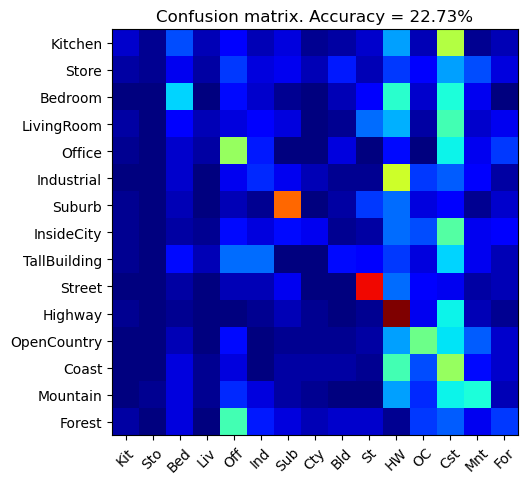

In [6]:
show_results(test_labels, categories, abbr_categories,predicted_labels, 'cm.png')

## Section 2: Bag of SIFT features with Nearest Neighbor classifier

### Section 2a: Represent each image with the Bag of SIFT feature

Now we will implement a more advanced feature set to describe our images - SIFT features! To build the SIFT vocabulary for bag of words, you will need to implement the k-means clustering algorithm and utilize it in your build vocabulary function.

To begin with, we have provided you with a simple visual demo on how kmeans works. No need to write any code yet, run the next cell, and play around with the slider to check the kmeans clustering process. (Credits to teaching staff from CS6601; thank you Prof. Starner!)

In [7]:
from ipywidgets import *
import matplotlib.pyplot as plt
K = 3
data = np.load('../proj3_unit_tests/test_data/kmeans.npz', allow_pickle=True)
print(data)
X = data['X']
y = data['y']
means_history = data['means']
clusters_history = data['clu']

# This is an interactive cell to see the progress of training your K-means algorithm.
# Feel free to improve the visualization code and share it with your classmates on Piazza
def get_cluster(i):
    clusters = clusters_history[i] # Get the clusters from K-means' i-th iteration
    plt.figure(None, figsize=(15,6)) # Set the plot size
    plt.suptitle('Drag the slider to see the algorthm training progress')
    ax1=plt.subplot(1, 2, 1)
    ax1.set_title('K-means clsuters - step %d' % i)
    for k in range(K):
        plt.plot(X[clusters==k,0], X[clusters==k,1], '.')
    # Just to get a flavour of how the data looks like
    ax2=plt.subplot(1, 2, 2)
    ax2.set_title('Ground truth clusters')
    for i in np.unique(y):
        ax2.plot(X[y==i,0],X[y==i,1],'.')

    plt.show()

interactive(get_cluster, i=(1,len(clusters_history)-1,1))

NpzFile '../proj3_unit_tests/test_data/kmeans.npz' with keys: X, y, means, clu


interactive(children=(IntSlider(value=5, description='i', max=10, min=1), Output()), _dom_classes=('widget-int…

In [8]:
print("test_kmeans_2_classes_1d_features()" + verify(test_kmeans_2_classes_1d_features))
print("test_kmeans_5_classes_2d_features()" + verify(test_kmeans_5_classes_2d_features))

print("test_kmeans_2_classes_1d_features()" + verify(test_build_vocabulary_shape))
print("test_kmeans_5_classes_2d_features()" + verify(test_build_vocabulary_values))

test_kmeans_2_classes_1d_features()"Correct"
test_kmeans_5_classes_2d_features()"Correct"
test_kmeans_2_classes_1d_features()"Correct"


C:\Users\gyroc\miniconda3\envs\proj3\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\b\abs_2112s1s0to\croot\pytorch-select_1700158736573\work\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


test_kmeans_5_classes_2d_features()"Correct"


To create a new vocabulary, make sure `vocab_filename` is different than the old vocabulary, or delete the old one.

**Important: note the logic for this cell: if the vocab file is present in the directory, then we'll proceed directly to getting SIFT representations; otherwise the vocab is built from scratch. The first time you run the cell, expect running time to be at least 10 minutes, as we are building the vocab as well as getting SIFT representations at the same time. Hence, make sure that you have passed all unit tests for this section before proceeding with the following cell!**

In [9]:
print('Using the BAG-OF-SIFT representation for images')

vocab_size = 50  # Larger values will work better (to a point) but be much slower to compute
stride = 20
max_iter = 10
vocab_filename = "../data/vocab.pkl"

if not osp.isfile(vocab_filename):
    # Construct the vocabulary
    print('No existing visual word vocabulary found. Computing one from training images')
    vocab = sc.build_vocabulary(train_image_arrays, vocab_size, stride, max_iter)
    with open(vocab_filename, 'wb') as f:
        pickle.dump(vocab, f)
        print('{:s} saved'.format(vocab_filename))
else:
    with open(vocab_filename, 'rb') as f:
        vocab = pickle.load(f)

Using the BAG-OF-SIFT representation for images


Now that we have built our vocabulary of visual words, we will use it to process our training and testing images.

You will need to implement two analagous functions to run the cell below

**Note: running on the full dataset will take some time**

In [10]:
print("test_kmeans_quantize_exact_matches()" + verify(test_kmeans_quantize_exact_matches))
print("test_kmeans_quantize_noisy_continuous()" + verify(test_kmeans_quantize_noisy_continuous))

print("test_get_bags_of_sifts()" + verify(test_get_bags_of_sifts))

test_kmeans_quantize_exact_matches()"Correct"
test_kmeans_quantize_noisy_continuous()"Correct"


Bag of SIFTs Progress: 100%|███████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.68s/it]

test_get_bags_of_sifts()"Correct"


In [ ]:
# This may take a long time to run depending on stride. 
# You may want to save the features for faster experimentation.

bags_of_sift_stride = 5
train_image_feats = sc.get_bags_of_sifts(train_image_arrays, vocab, bags_of_sift_stride)
test_image_feats = sc.get_bags_of_sifts(test_image_arrays, vocab, bags_of_sift_stride)

Bag of SIFTs Progress:   3%|█▋                                                       | 46/1500 [00:26<13:16,  1.82it/s]c:\users\gyroc\pycharmprojects\computer-vision-homework\hw\ps3\proj3_code\feature_matching\SIFTNet.py:452: RuntimeWarning: invalid value encountered in divide
  fvs /= np.linalg.norm(fvs, axis=1, keepdims=True)
Bag of SIFTs Progress:  13%|███████▏                                                | 191/1500 [01:47<13:07,  1.66it/s]

### Section 2b: Classify each test image by training and using the Nearest Neighbor classifier

In [ ]:
print('Using NEAREST NEIGHBOR classifier to predict test set categories')
predicted_categories = sc.nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats, k = 3)

### Section 2c: Build a confusion matrix and score the recognition system

In [ ]:
show_results(test_labels, categories, abbr_categories, predicted_categories, 'cm.png')

## Conclusion
We have seen that a basic classifier as simple as kNN is sufficient to get this classification task done with around 50% accuracy; you may choose to experiment with SVM classifier, which can boost your performance up to 60%, but that's not required for this project.

This shows you how things are done in the pre-deep learning era, and the result is, uh, okay. These days with neural networks, 80% ~ 90% accuracies can be achieved with ease.